In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import utils
from models import DIP

In [3]:
# clean = utils.load_celeba(10)
# clean = utils.load_images('./data/celeba10/')
clean = utils.load_image('./data/set5/butterfly.png')
noisy = torch.stack([utils.get_noisy_image(img, 0.1) for img in clean])

In [4]:
input_channels = 3
deep_channels = [8, 16, 32, 64, 128]
skip_channels = [0, 0, 0, 4, 4]

dip = DIP(input_channels, deep_channels, skip_channels, epochs=2400)

denoised = []
for i in range(len(noisy)):
  denoised.append(dip.denoise(noisy[[i]], id=i, verbose=False))
denoised = torch.cat(denoised)

0: Training on cuda:0
----------
Finished training in 00:01:11



In [5]:
denoised = denoised.detach().cpu()
noisy = noisy.cpu()

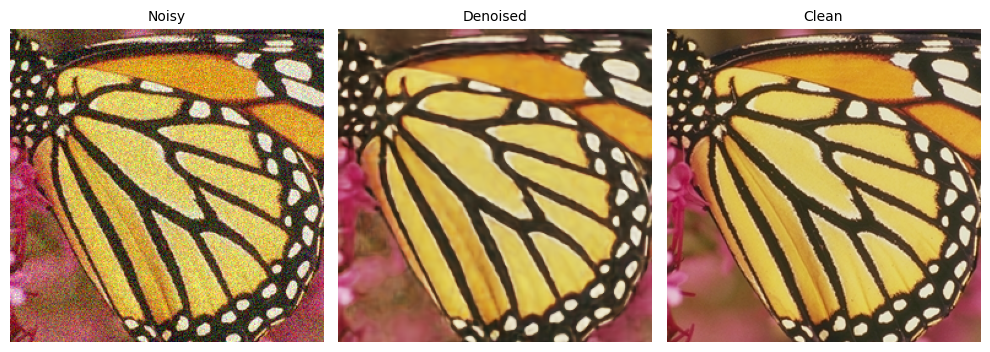

In [6]:
for n, d, c in zip(noisy, denoised, clean):
  utils.plot_row([n, d, c], ['Noisy', 'Denoised', 'Clean'])

In [7]:
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure

psnr = PeakSignalNoiseRatio(reduction=None, data_range=1, dim=[1, 2, 3])
noisy_psnr = psnr(noisy, clean)
denoised_psnr = psnr(denoised, clean)

print('PSNR:')
print('----------')
print('Mean:')
print(f'Noisy:\t\t{noisy_psnr.mean()}')
print(f'Denoised:\t{denoised_psnr.mean()}')
print('\nElement-wise:')
print(f'Noisy:\t\t{noisy_psnr.tolist()}')
print(f'Denoised:\t{denoised_psnr.tolist()}')

PSNR:
----------
Mean:
Noisy:		20.304845809936523
Denoised:	27.802471160888672

Element-wise:
Noisy:		20.304845809936523
Denoised:	27.802471160888672


In [8]:
ssim = StructuralSimilarityIndexMeasure(reduction=None, data_range=1)
noisy_ssim = ssim(noisy, clean)
denoised_ssim = ssim(denoised, clean)

print('SSIM:')
print('----------')
print('Mean:')
print(f'Noisy:\t\t{noisy_ssim.mean()}')
print(f'Denoised:\t{denoised_ssim.mean()}')
print('\nElement-wise:')
print(f'Noisy:\t\t{noisy_ssim.tolist()}')
print(f'Denoised:\t{denoised_ssim.tolist()}')

SSIM:
----------
Mean:
Noisy:		0.5132205486297607
Denoised:	0.8809863924980164

Element-wise:
Noisy:		0.5132205486297607
Denoised:	0.8809863924980164
